# Grade Predictor
Given a student's transcript of 7 courses, predict the grades of an 8th course.

## Imports and setup
This is similar to `models.ipynb`. We will be using **Approach 3** only.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import math
import diffprivlib.models as dp
import numpy as np

In [2]:
sns.set()

def plot():
    plt.figure(dpi=200, figsize=(8, 5))

In [3]:
transcripts = pd.read_csv('transcripts.csv', index_col=0, low_memory=False)
transcripts.head()

,DIRECTED STUDY,INTRODUCTION TO COMPUTER ENGINEERING,INTRODUCTION TO DISCRETE MATHEMATICS,MACHINE ORGANIZATION AND PROGRAMMING,DIGITAL SYSTEM FUNDAMENTALS,INTRODUCTION TO ARTIFICIAL INTELLIGENCE,PROBLEM SOLVING USING COMPUTERS,INTRODUCTION TO OPERATING SYSTEMS,INTRODUCTION TO ALGORITHMS,DATABASE MANAGEMENT SYSTEMS: DESIGN AND IMPLEMENTATION,...,MEDICAL IMAGE ANALYSIS,VIRTUAL REALITY,COMPUTER ANIMATION,INTRODUCTION TO COMPUTATIONAL GEOMETRY,FUNDAMENTALS OF HUMAN-COMPUTER INTERACTION,COMPUTATIONAL METHODS FOR MEDICAL IMAGE ANALYSIS,CONTEST-LEVEL PROGRAMMING,USER EXPERIENCE DESIGN 1,ADVANCED LINEAR PROGRAMMING,SENIOR THESIS
0,NaN,NaN,AB,NaN,NaN,NaN,NaN,NaN,BC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,BC,NaN,A,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,AB,BC,NaN,AB,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,AB,AB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
grade_to_label_dict = {'A': 1, 'AB': 2, 'B': 3, 'BC': 4, 'C': 5, 'D': 6, 'F': 7}
label_to_grade_dict = {value: key for key, value in grade_to_label_dict.items()}

In [5]:
course_to_index_dict = {column: i for i, column in enumerate(transcripts.columns)}
index_to_course_dict = {i: column for i, column in enumerate(transcripts.columns)}

In [6]:
transcripts_preprocessed = transcripts.fillna(0).replace(grade_to_label_dict).astype(int)

In [7]:
x = []
y = []
for index, grades in transcripts_preprocessed.iterrows():
    grade_indices = grades[grades != 0].index
    for course in grade_indices:
        new_grades = grades.copy()
        new_grades[course] = -1
        x.append(new_grades)
        y.append(grades[course])
x = np.asarray(x)
y = np.asarray(y)

## Models

In [8]:
epsilon = 0.1

### Logistic Regression

In [9]:
logistic_regression_model = LogisticRegression(solver='sag', multi_class='multinomial', max_iter=10_000)
logistic_regression_model.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

### Naive Bayes

In [10]:
naive_bayes_model = GaussianNB(var_smoothing=1)
naive_bayes_model.fit(x, y)

GaussianNB(priors=None, var_smoothing=1)

### Logistic Regression (DP)

In [11]:
max_norm = np.linalg.norm(x, axis=1).max()
dp_logistic_regression_model = dp.LogisticRegression(max_iter=10_000, data_norm=max_norm, epsilon=epsilon)
dp_logistic_regression_model.fit(x, y)

LogisticRegression(C=1.0, data_norm=15.231546211727817, epsilon=0.1,
                   fit_intercept=True, max_iter=10000, n_jobs=None, tol=0.0001,
                   verbose=0, warm_start=False)

### Naive Bayes (DP)

In [12]:
bounds = [(1, 7) for i in range(x.shape[1])]
dp_naive_bayes_model = dp.GaussianNB(bounds=bounds, epsilon=epsilon, var_smoothing=1)
dp_naive_bayes_model.fit(x, y)

GaussianNB(bounds=[(1, 7), (1, 7), (1, 7), (1, 7), (1, 7), (1, 7), (1, 7),
                   (1, 7), (1, 7), (1, 7), (1, 7), (1, 7), (1, 7), (1, 7),
                   (1, 7), (1, 7), (1, 7), (1, 7), (1, 7), (1, 7), (1, 7),
                   (1, 7), (1, 7), (1, 7), (1, 7), (1, 7), (1, 7), (1, 7),
                   (1, 7), (1, 7), ...],
           epsilon=0.1, priors=None, var_smoothing=1)

Put the models in a dictionary so we can iterate over them more easily for predictions:

In [13]:
models = {
    'Logistic Regression': logistic_regression_model,
    'Naive Bayes': naive_bayes_model,
    'Logistic Regression (DP)': dp_logistic_regression_model,
    'Naive Bayes (DP)': dp_naive_bayes_model
}

## Predictor

First, we have to select the 7 courses that the student has already taken up. The following dictionary will list the course numbers for each course:

In [14]:
course_to_index_dict

{'DIRECTED STUDY': 0,
 'INTRODUCTION TO COMPUTER ENGINEERING': 1,
 'INTRODUCTION TO DISCRETE MATHEMATICS': 2,
 'MACHINE ORGANIZATION AND PROGRAMMING': 3,
 'DIGITAL SYSTEM FUNDAMENTALS': 4,
 'INTRODUCTION TO ARTIFICIAL INTELLIGENCE': 5,
 'PROBLEM SOLVING USING COMPUTERS': 6,
 'INTRODUCTION TO OPERATING SYSTEMS': 7,
 'INTRODUCTION TO ALGORITHMS': 8,
 'DATABASE MANAGEMENT SYSTEMS: DESIGN AND IMPLEMENTATION': 9,
 'INTRODUCTION TO PROGRAMMING LANGUAGES AND COMPILERS': 10,
 'INTRODUCTION TO NUMERICAL METHODS': 11,
 'INTRODUCTION TO COMPUTER ARCHITECTURE': 12,
 'INTRODUCTION TO CRYPTOGRAPHY': 13,
 'INTRODUCTION TO COMPUTER NETWORKS': 14,
 'MACHINE LEARNING': 15,
 'UNDERGRADUATE TOPICS IN COMPUTING': 16,
 'COMPUTER GRAPHICS': 17,
 'INTRODUCTION TO COMBINATORICS': 18,
 'INTRODUCTION TO COMPUTATION': 19,
 'TOPICS IN COMPUTING': 20,
 'PROGRAMMING I': 21,
 'INTRODUCTION TO THEORY OF COMPUTING': 22,
 'FOUNDATIONS OF MOBILE SYSTEMS AND APPLICATIONS': 23,
 'SOFTWARE ENGINEERING': 24,
 'INTRODUCTION T

In [15]:
existing_courses_list = [
    30,    # course 1
    27,    # course 2
    24,    # course 3
    13,    # course 4
    14,    # course 5
    17,    # course 6
    22,    # course 7
]

Next, input the grades for each course, using the following dictionary:

In [16]:
grade_to_label_dict

{'A': 1, 'AB': 2, 'B': 3, 'BC': 4, 'C': 5, 'D': 6, 'F': 7}

In [17]:
grades_list = [
    1,   # grade for course 1
    2,   # grade for course 2
    3,   # grade for course 3
    1,   # grade for course 4
    2,   # grade for course 5
    3,   # grade for course 6
    2,   # grade for course 7
]

#### Graphing
Let's visualize your transcript!

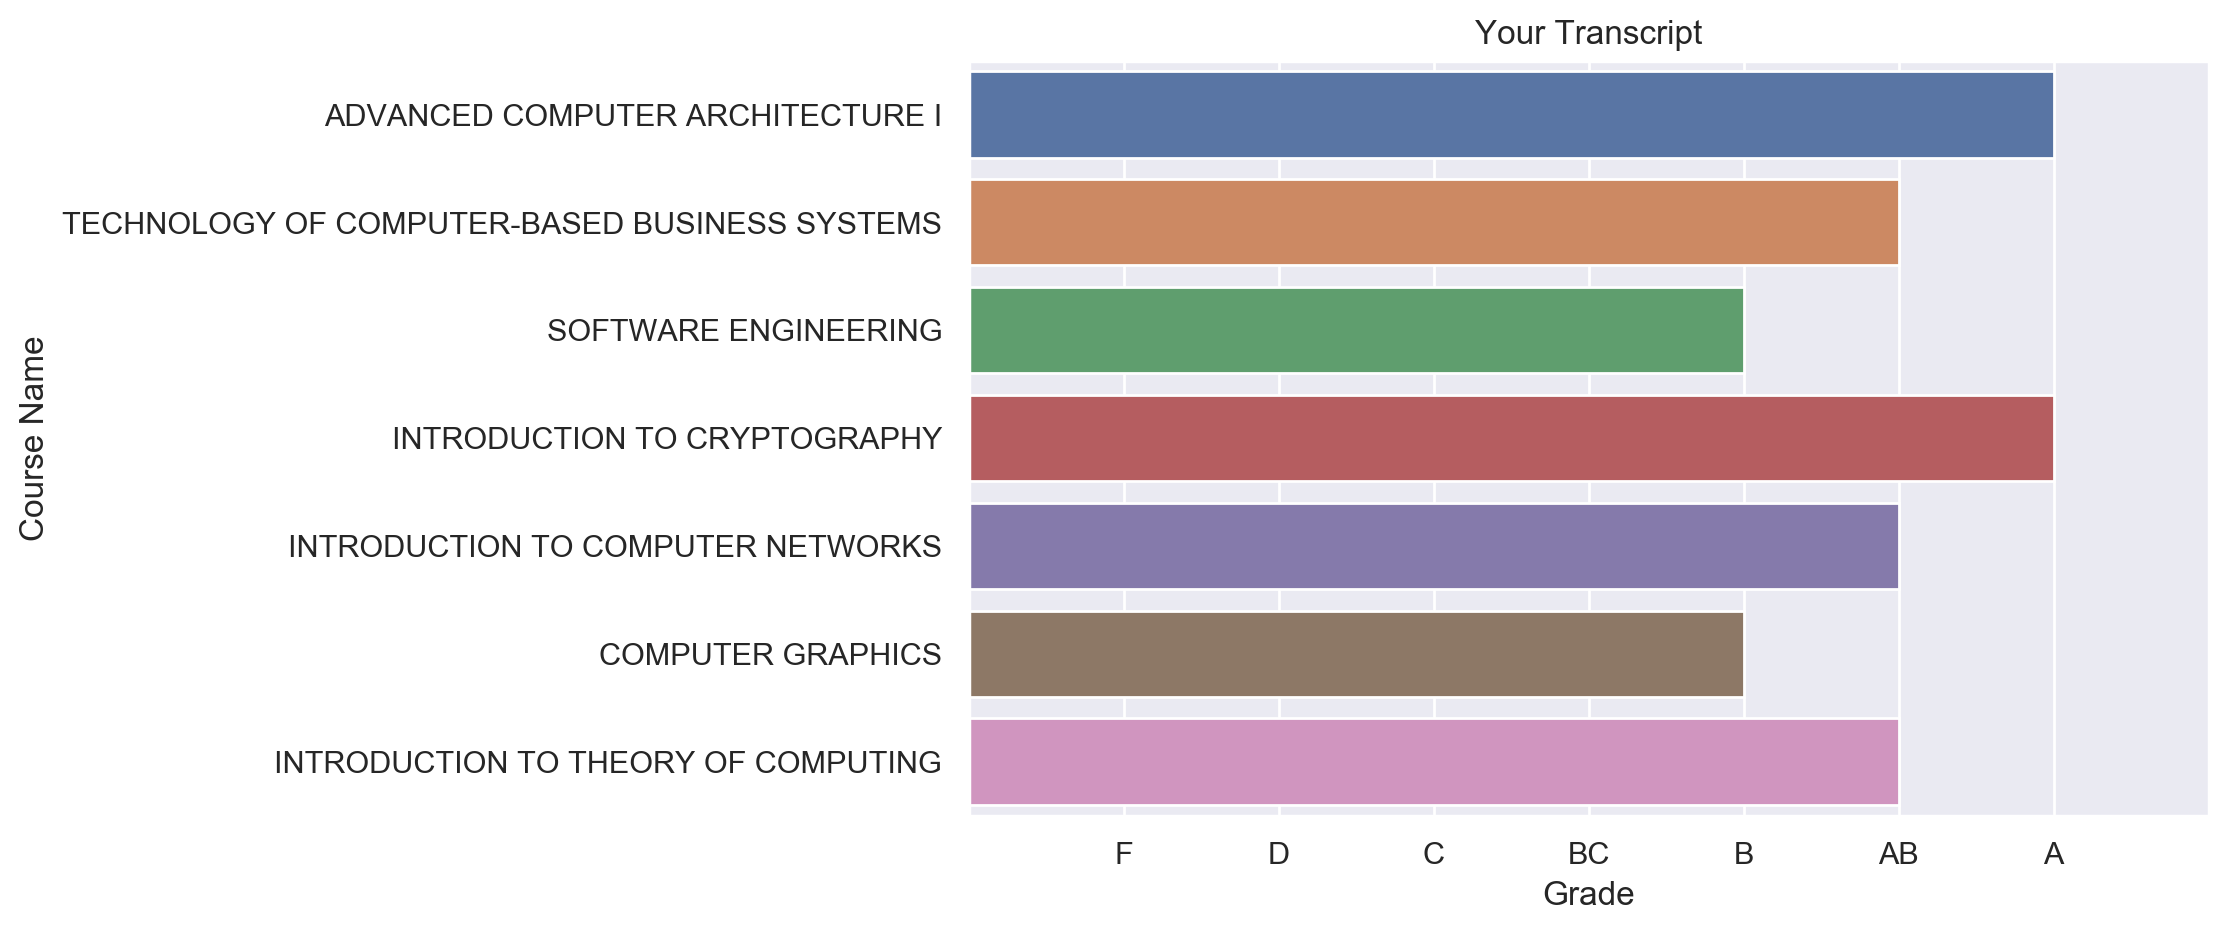

In [18]:
grade_values = grade_to_label_dict['F'] - np.asarray(grades_list) + 1
course_names = [index_to_course_dict[course_number] for course_number in existing_courses_list]
plot()
sns.barplot(x=grade_values, y=course_names)
plt.xlabel('Grade')
plt.ylabel('Course Name')
x_ticks = list(grade_to_label_dict.keys())
x_ticks.sort(reverse=True)
x_ticks.insert(0, '')
plt.xticks(ticks=list(range(len(x_ticks)+1)), labels=x_ticks)
plt.title('Your Transcript');

Finally, just put down the course number of the course whose grade you want to predict!

In [19]:
course_number_to_predict = 71

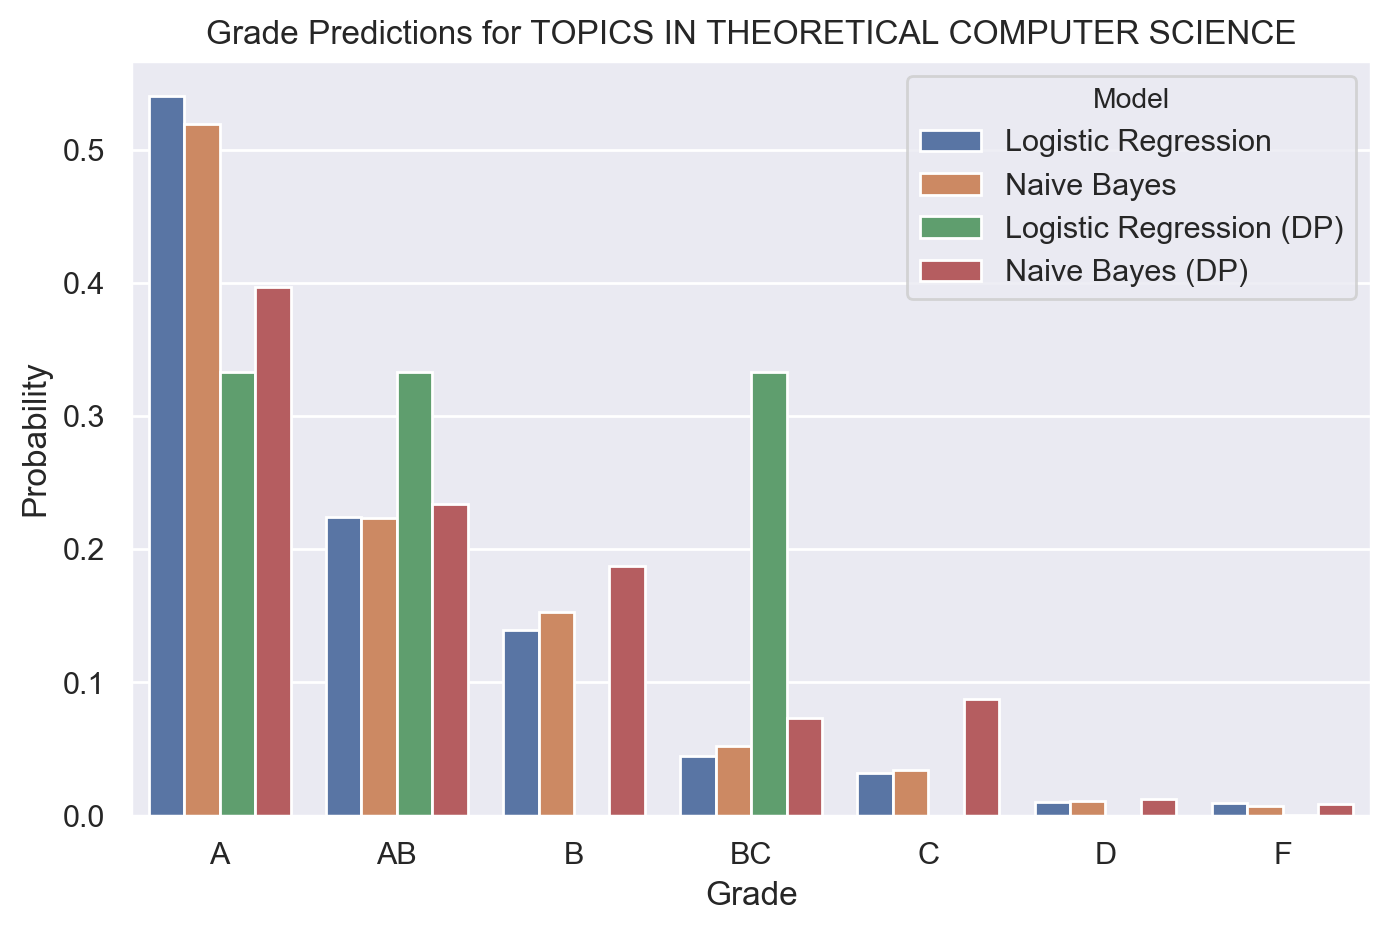

In [20]:
transcript = pd.Series(index=transcripts_preprocessed.columns)
for existing_course, grade in zip(existing_courses_list, grades_list):
    course_name = index_to_course_dict[existing_course]
    transcript[course_name] = grade
transcript[index_to_course_dict[course_number_to_predict]] = -1
transcript = transcript.fillna(0)

grade_probabilities_df = pd.DataFrame(columns=['Model', 'Grade', 'Probability'])
for (model_name, model) in models.items():
    grade_probabilities = model.predict_proba(transcript.to_numpy().reshape(1, -1))[0, :]
    for (i, probability) in enumerate(grade_probabilities):
        row = pd.Series(index=grade_probabilities_df.columns)
        row['Model'] = model_name
        row['Grade'] = label_to_grade_dict[i+1]
        row['Probability'] = probability
        grade_probabilities_df = grade_probabilities_df.append(row, ignore_index=True)

plot()
sns.barplot(x='Grade', y='Probability', hue='Model', data=grade_probabilities_df)
plt.title('Grade Predictions for %s' % index_to_course_dict[course_number_to_predict]);